In [57]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

In [58]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

In [59]:
data = r'data/arxiv_artificial_life.csv'

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

# remove everything that doesn't mention artificial life explicitely in the summary; too aggressive, but useful for now
mask = df['summary'].str.contains('artificial life', case=False)
df = df[mask]

df = df[['authors', 'title']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

df.head()

,authors,title
0,Alessandro Scirè,Emergence and criticality in spatiotemporal sy...
1,Lakshwin Shreesha,Role of Morphogenetic Competency on Evolution
2,M Charity,Amorphous Fortress: Observing Emergent Behavio...
3,Dipika Rajesh,Amorphous Fortress: Observing Emergent Behavio...
4,Sam Earle,Amorphous Fortress: Observing Emergent Behavio...


In [60]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(df, source='authors', target='title')
G = bipartite.projected_graph(B, df['authors'])

In [61]:
print(nx.info(G))

Graph with 307 nodes and 2026 edges


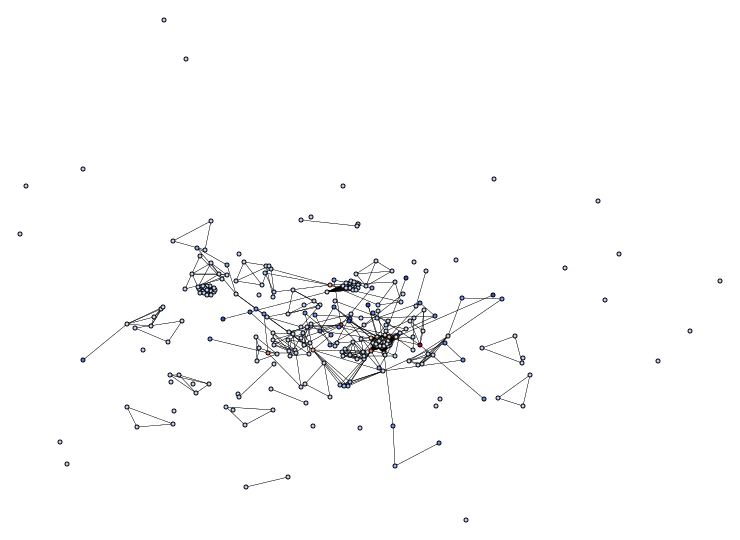

In [65]:
# this is artificial life without labels; it runs fast because this is a small network

draw_graph(G, node_size=2, show_names=False, edge_width=0.3)

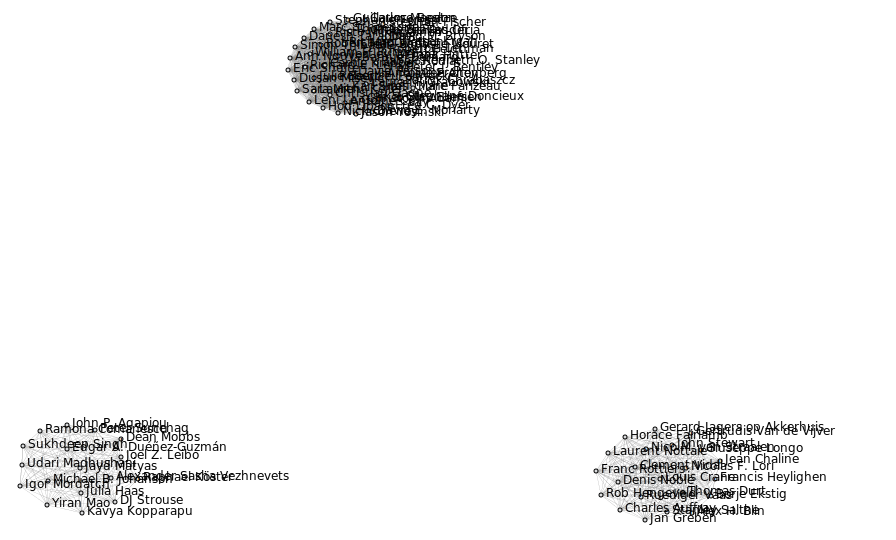

In [66]:
# this is the core of the network science network with labels; the largest cluster in the bipartite projection

draw_graph(nx.k_core(G, 10), node_size=2, font_size=12, show_names=True, edge_width=0.1)

In [67]:
nodes = list(nx.k_core(G, 10).nodes)
df[df['authors'].isin(nodes)]['title'].value_counts()[0:20]

The Surprising Creativity of Digital Evolution: A Collection of Anecdotes from the Evolutionary Computation and Artificial Life Research Communities    53
The Evolution and Development of the Universe                                                                                                           22
Melting Pot 2.0                                                                                                                                         17
Safe Mutations for Deep and Recurrent Neural Networks through Output Gradients                                                                           3
Open Questions in Creating Safe Open-ended AI: Tensions Between Control and Creativity                                                                   2
Machine Love                                                                                                                                             1
The Agent-based Modelling for Human Behaviour Special Issue           

# Egocentric Network Analysis

As the above visualization shows, this is a complex network. For knowledge discovery, we should use Egocentric Network Analysis to "zoom in" on nodes of interest. Any node can be looked at, but I am going to programmatically do this, in this notebook, showing only the top twenty nodes, according to page rank.

# PageRank - Identify Nodes of Interest

In [68]:
page_rank = nx.pagerank(G)

pr_df = pd.DataFrame().from_dict(page_rank, orient='index')
pr_df.columns = ['page_rank']
pr_df.sort_values('page_rank', ascending=False, inplace=True)
pr_df.head(10)

,page_rank
Carlos Gershenson,0.008318
Stefano Nichele,0.007661
Tomas Mikolov,0.007012
Kenneth O. Stanley,0.006984
Julian Togelius,0.006033
Takashi Ikegami,0.005804
Risto Miikkulainen,0.005735
James M. Borg,0.005613
Charles Ofria,0.005507
Christoph Adami,0.005050


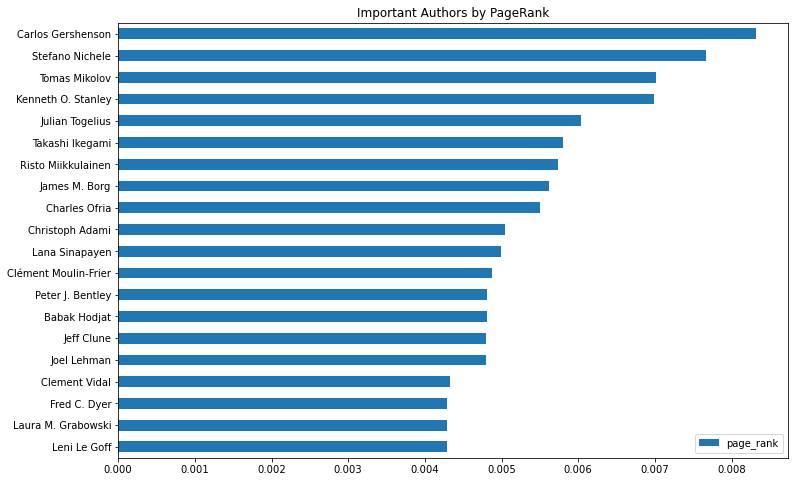

In [69]:
title = 'Important Authors by PageRank'

pr_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

# Egocentric Network Analysis
Next, let's look at the Ego Graphs for each of the top ten characters found by PageRank. Before visualizing and inspecting the Ego Graphs, let's create a Python list so that we can more easily look through them without explicitely typing their names.

In [70]:
top_nodes = pr_df.head(20).index.values

In [71]:
top_nodes[0]

'Carlos Gershenson'

Now we are all set to start looking through them, in order of importance.

## Top Node Ego Networks
Unlike last time, I am not going to drop the center node or write about findings. This is purely discovery. Remember two things:
- The center node is known as the 'ego' node. It is the node being looked up.
- The other nodes are known as 'alter' nodes. They are connected to the ego node, and sometimes with each other.

Pay close attention to the alter nodes that link to other alter nodes. These are interesting relationships, and you can see subcommunities in the ego network. Think about what you are seeing. What does this tell you?

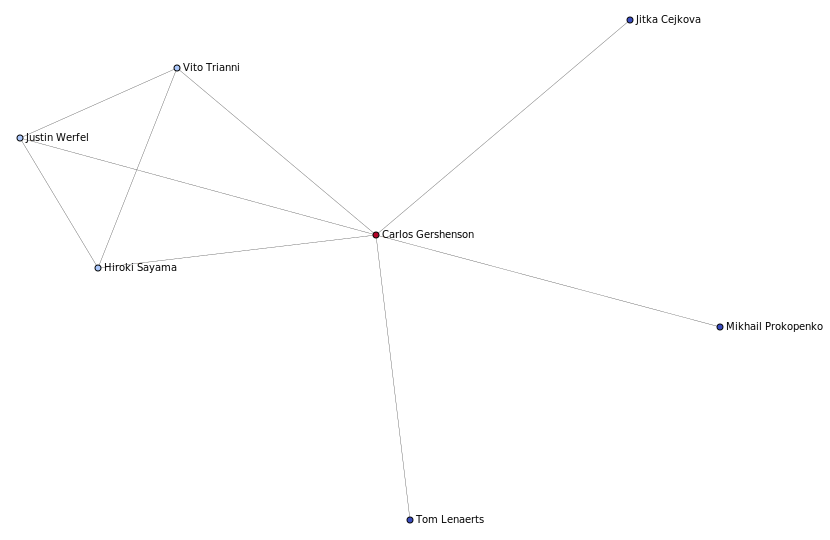

In [72]:
ego = top_nodes[0]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

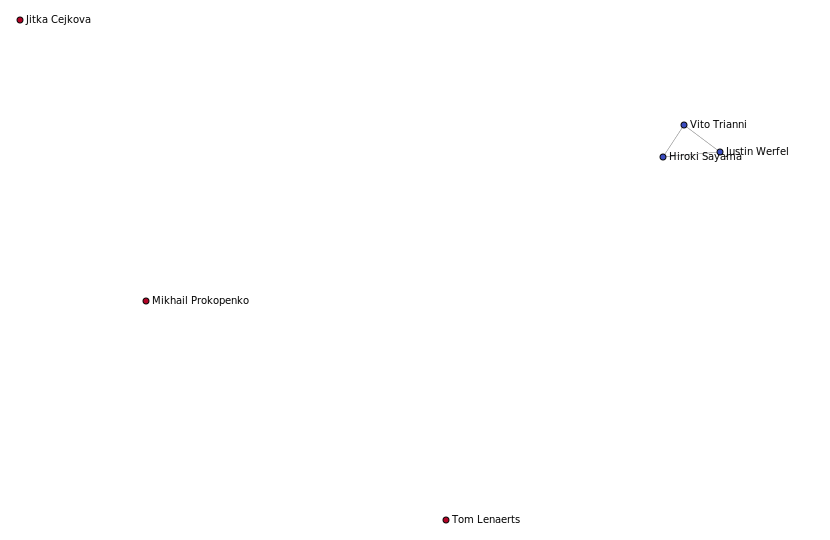

In [73]:
ego = top_nodes[0]

G_ego = nx.ego_graph(G, ego, center=False)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

In [74]:
# you can look at what articles the author was part of this way, going from networks to NLP

sorted(df[df['authors']==ego]['title'])

['Artificial life: sustainable self-replicating systems',
 'Complex Networks',
 'Emergence in artificial life',
 'Evolution of Complexity',
 'Evolution of Complexity: Introduction to the Workshop',
 'Intelligence as information processing: brains, swarms, and computers',
 'Introduction to Random Boolean Networks',
 'Self-Organization and Artificial Life',
 'Self-Organization and Artificial Life: A Review']

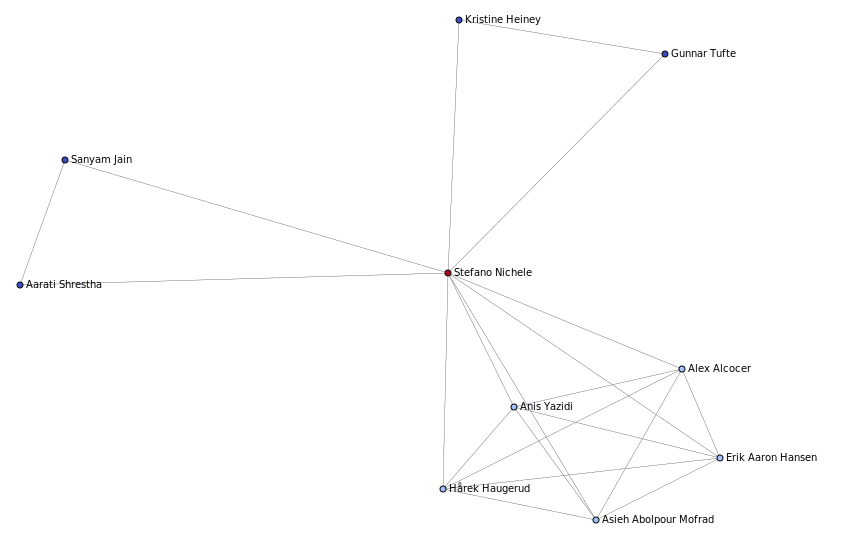

In [75]:
ego = top_nodes[1]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

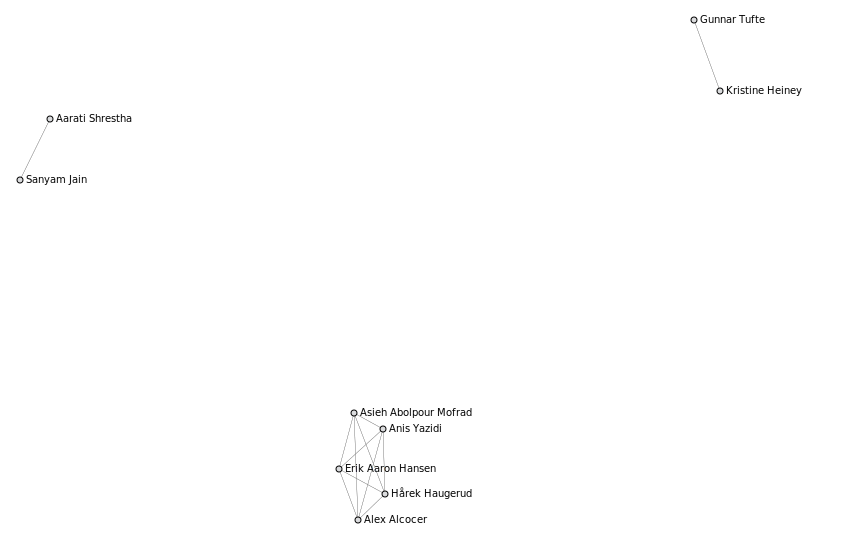

In [76]:
ego = top_nodes[1]

G_ego = nx.ego_graph(G, ego, center=False)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

In [77]:
# you can look at what articles the author was part of this way, going from networks to NLP

sorted(df[df['authors']==ego]['title'])

['Achieving Connectivity Between Wide Areas Through Self-Organising Robot Swarm Using Embodied Evolution',
 'Capturing Emerging Complexity in Lenia',
 'On Artificial Life and Emergent Computation in Physical Substrates']

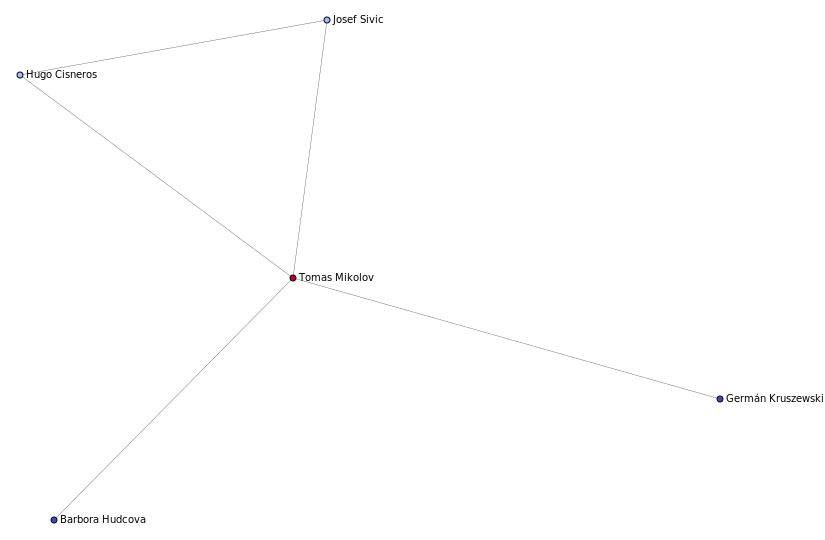

In [78]:
ego = top_nodes[2]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

In [79]:
# you can look at what articles the author was part of this way, going from networks to NLP

sorted(df[df['authors']==ego]['title'])

['Classification of Complex Systems Based on Transients',
 'Emergence of Self-Reproducing Metabolisms as Recursive Algorithms in an Artificial Chemistry',
 'Evolving Structures in Complex Systems']

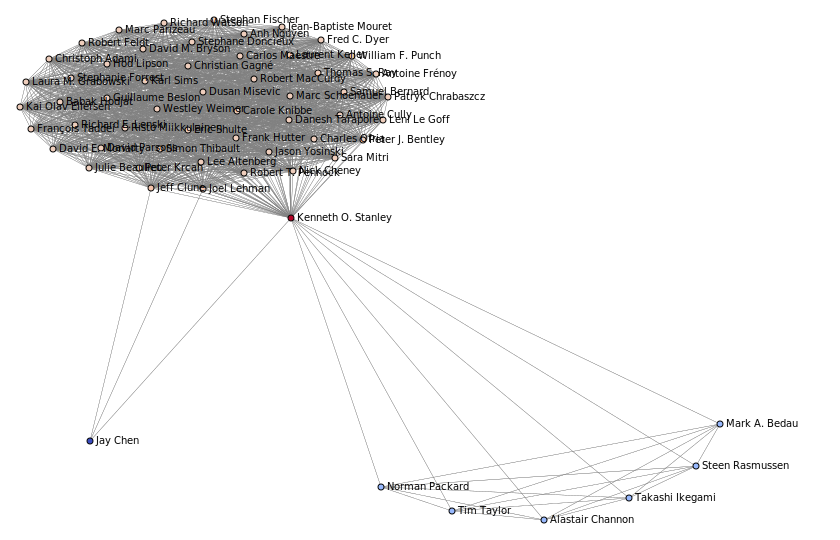

In [80]:
ego = top_nodes[3]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

In [81]:
# you can look at what articles the author was part of this way, going from networks to NLP

sorted(df[df['authors']==ego]['title'])

['An Overview of Open-Ended Evolution: Editorial Introduction to the Open-Ended Evolution II Special Issue',
 'Safe Mutations for Deep and Recurrent Neural Networks through Output Gradients',
 'The Surprising Creativity of Digital Evolution: A Collection of Anecdotes from the Evolutionary Computation and Artificial Life Research Communities']

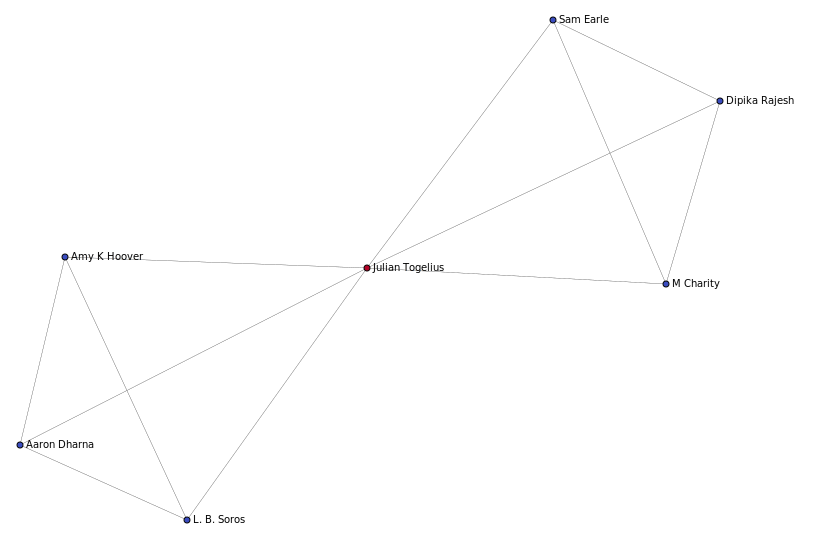

In [82]:
ego = top_nodes[4]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

In [83]:
# you can look at what articles the author was part of this way, going from networks to NLP

sorted(df[df['authors']==ego]['title'])

['Amorphous Fortress: Observing Emergent Behavior in Multi-Agent FSMs',
 'Co-generation of game levels and game-playing agents',
 'Transfer Dynamics in Emergent Evolutionary Curricula']

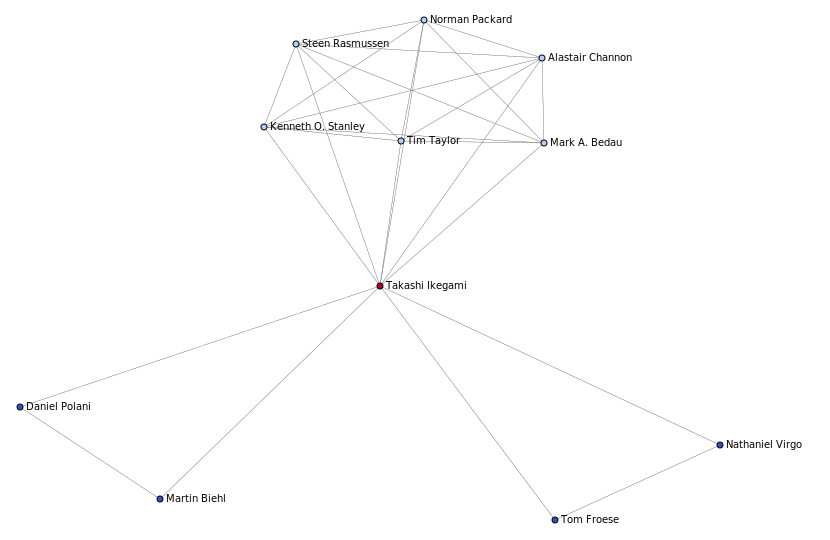

In [84]:
ego = top_nodes[5]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

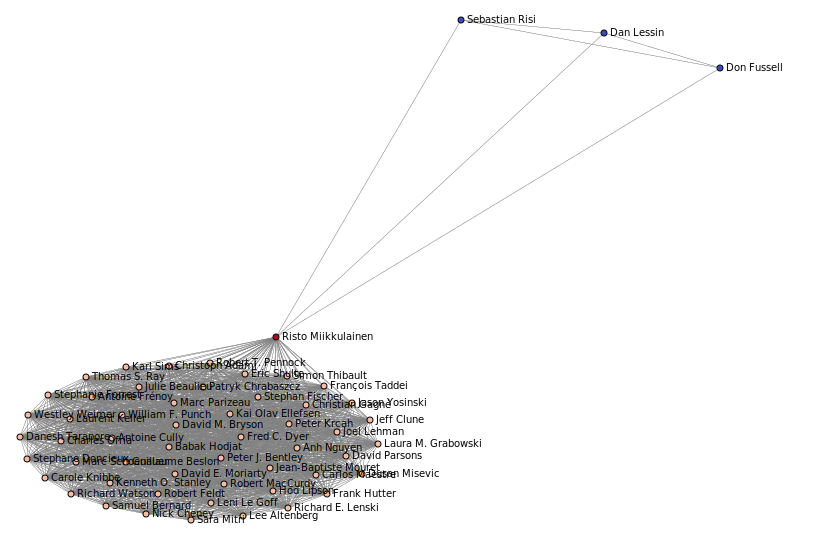

In [85]:
ego = top_nodes[6]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

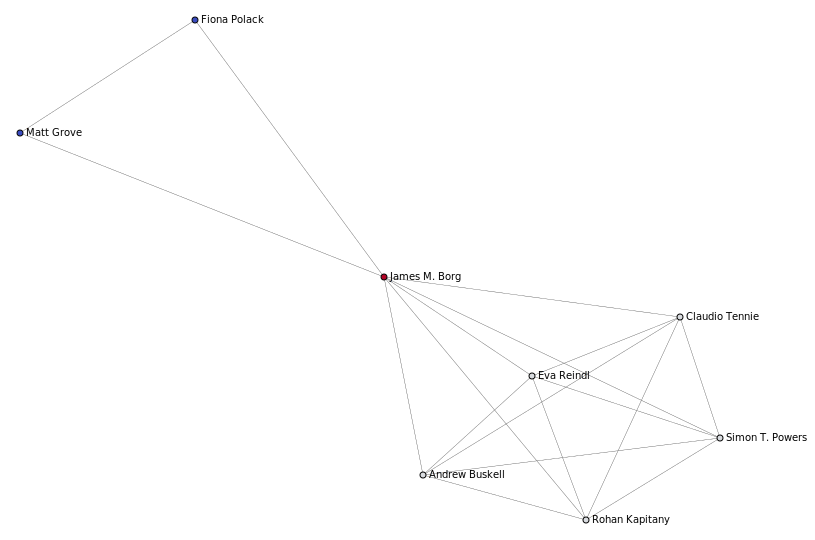

In [86]:
ego = top_nodes[7]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

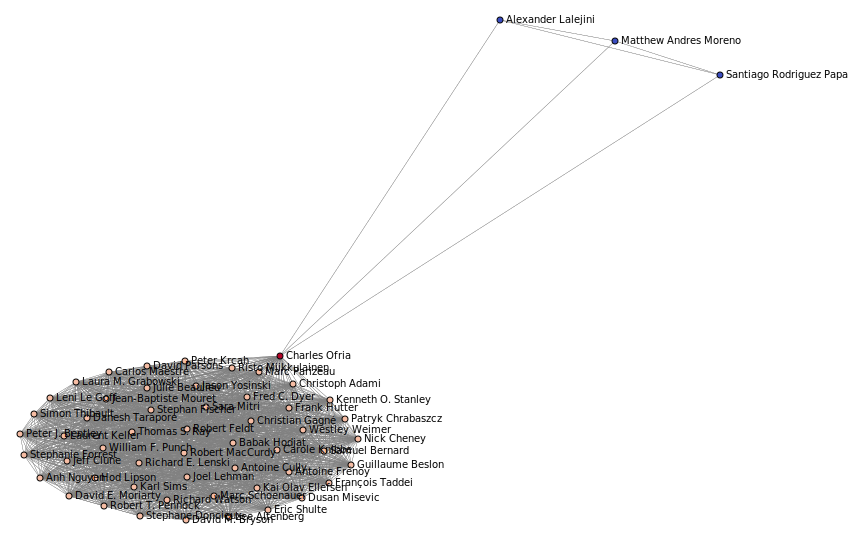

In [87]:
ego = top_nodes[8]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

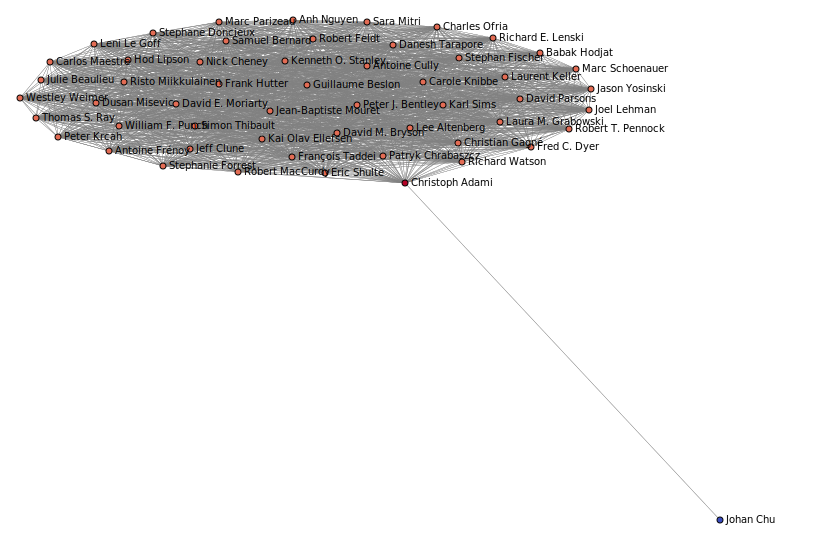

In [88]:
ego = top_nodes[9]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

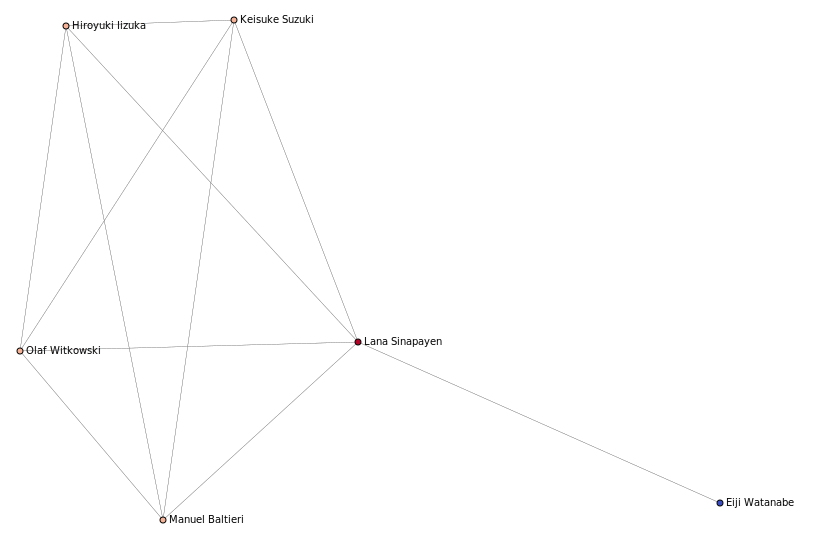

In [89]:
ego = top_nodes[10]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

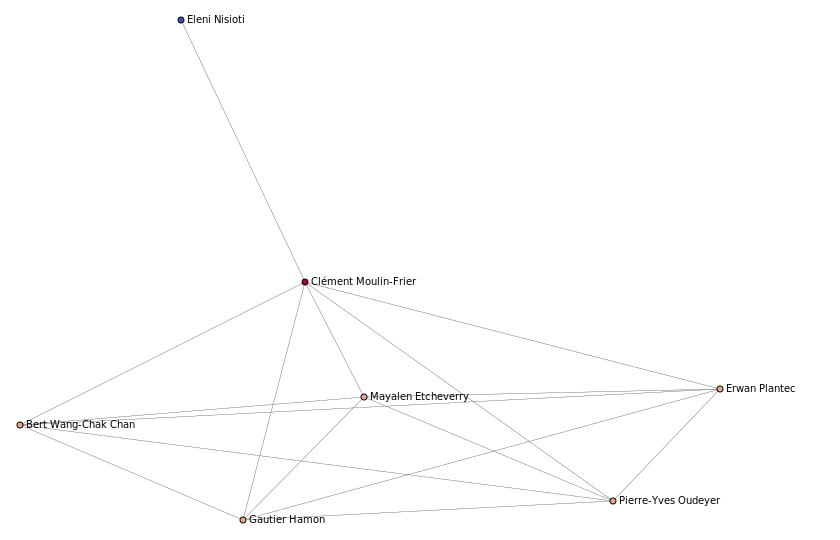

In [90]:
ego = top_nodes[11]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

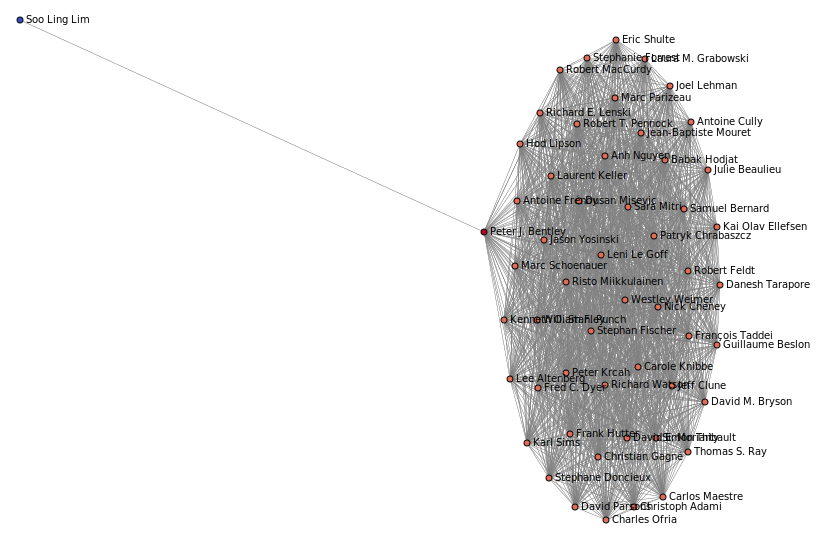

In [91]:
ego = top_nodes[12]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

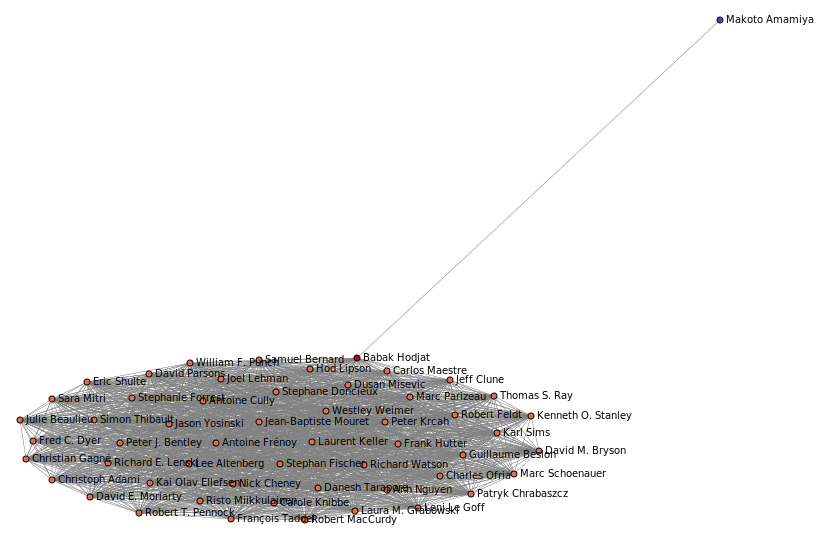

In [92]:
ego = top_nodes[13]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

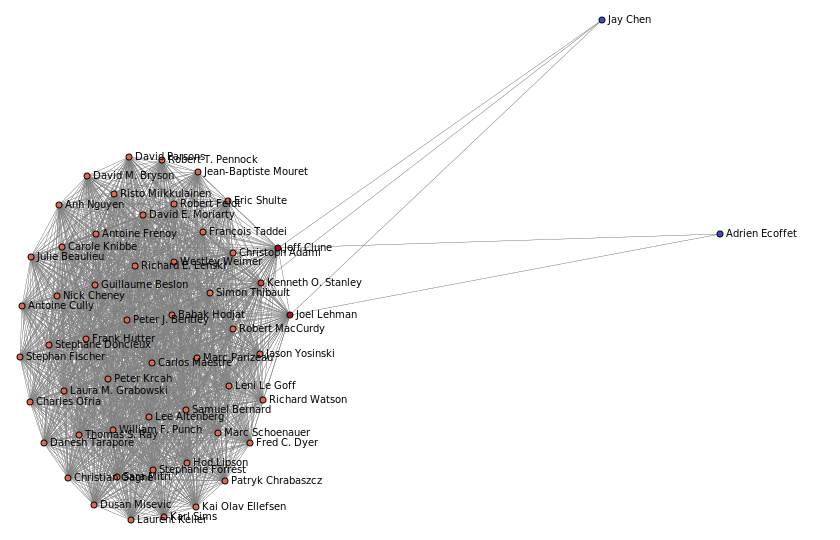

In [93]:
ego = top_nodes[14]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

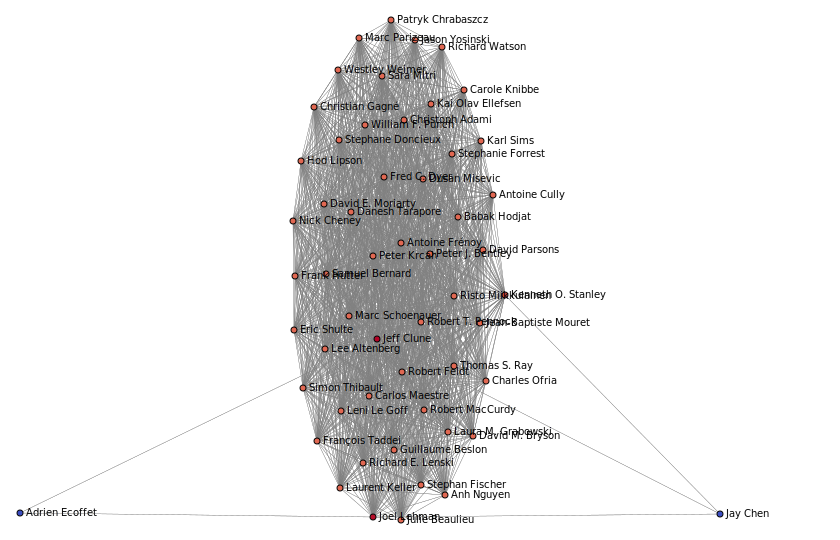

In [94]:
ego = top_nodes[15]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

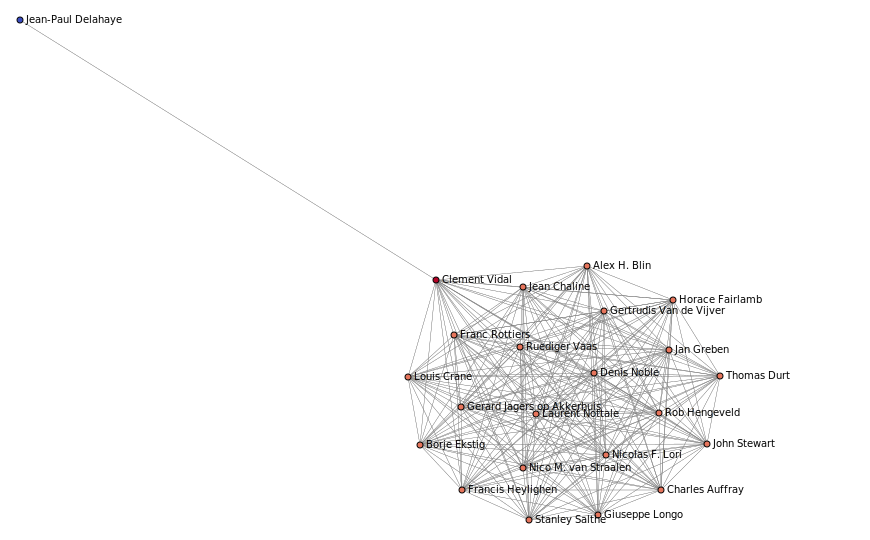

In [95]:
ego = top_nodes[16]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

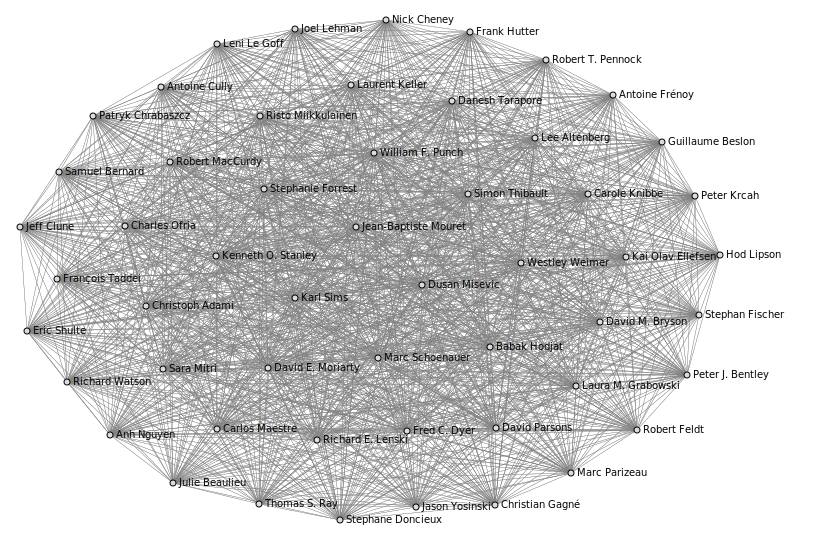

In [96]:
ego = top_nodes[17]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

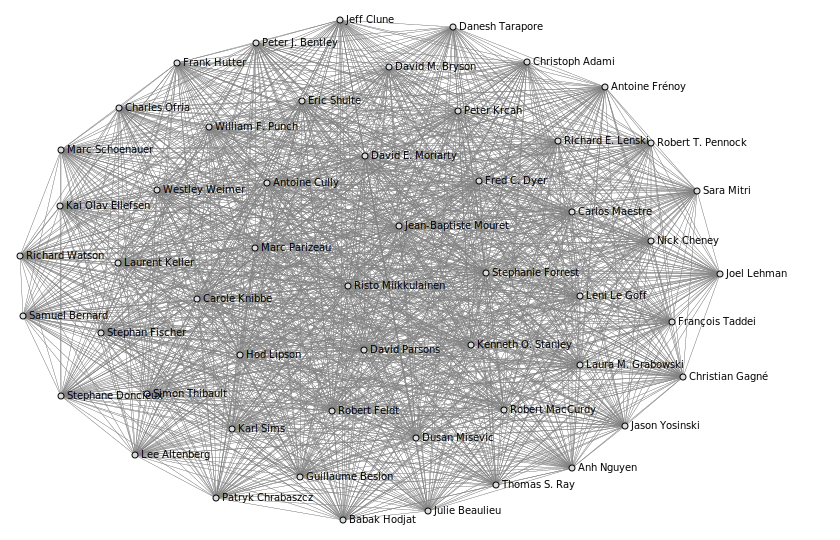

In [97]:
ego = top_nodes[18]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

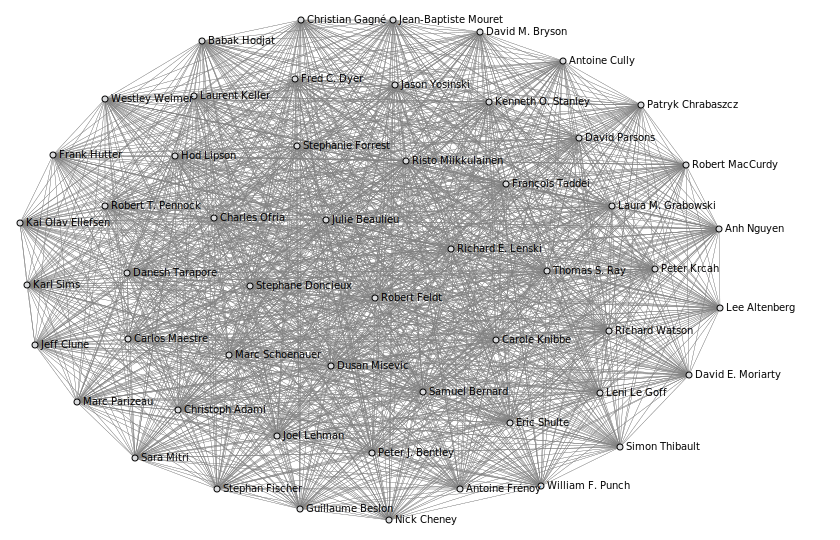

In [98]:
ego = top_nodes[19]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

# This is the Beginning

This is just the beginning of this network exploration. There are communities and connected components that should be explored. There are articles to read and authors to learn about and follow. We will certainly do more with these networks.